# Image Exploration for VIS-IR Dataset

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import jupyter_compare_view
import imutils
import os

from matplotlib.widgets import RangeSlider

Jupyter compare_view v0.2.4


## Load and process data

In [2]:
# Feel free to edit as you like depending on where you put the files
BASE_IMAGE_DIR = "VIS_IR_DATASET"
FILE_NAME = "2021-11-15_22-52-14.jpg"

In [3]:
im = cv2.imread(f"{BASE_IMAGE_DIR}/{FILE_NAME}")

In [4]:
# The default image shape is represented as (height, width, channels)
print(im.shape)

(2464, 6560, 3)


In [5]:
# The image contains the VIS and IR Image side by side
assert im.shape[1] % 2 == 0
im_vis = im[:, :(im.shape[1]//2), :]
im_ir = im[:, (im.shape[1]//2):, :]

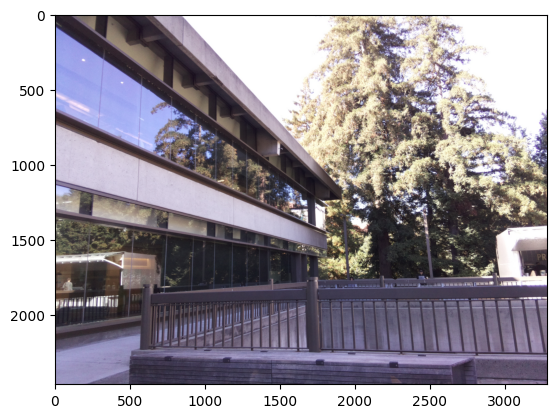

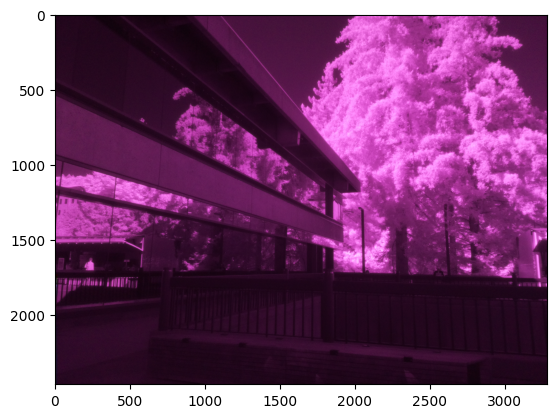

In [6]:
# Display the images for reference, all images must use cv2.cvtColor as cv2 stores images as BGR instead of RGB
plt.imshow(cv2.cvtColor(im_vis, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(im_ir, cv2.COLOR_BGR2RGB))
plt.show()

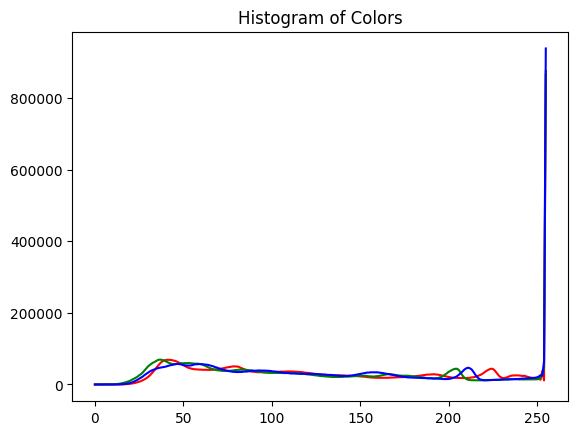

In [7]:
# Plot of a histogram of colors to see how they look. It is clear that the images are overexposed 
plt.title(f"Histogram of Colors")
channel_names = ["red", "green", "blue"]
for channel in range(3):
    hist = cv2.calcHist([im_vis], [channel], None, [256], [0, 256])
    plt.plot(hist, color=channel_names[channel]) 
plt.show()

## Utility Functions

In [8]:
# Align images code was taken from https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/
# tl;dr align images finds features within an image and an template and attempts to match them using the
# RANSAC algorithm then computes a homography matrix to align the image.

def align_images(image, template, maxFeatures=5000, keepPercent=0.1,
    debug=False):
    # convert both the input image and template to grayscale
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    # use ORB to detect keypoints and extract (binary) local
    # invariant features
    orb = cv2.ORB_create(maxFeatures)
    (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
    (kpsB, descsB) = orb.detectAndCompute(templateGray, None)
    # match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)
    
    # sort the matches by their distance (the smaller the distance,
    # the "more similar" the features are)
    matches = sorted(matches, key=lambda x:x.distance)
    # keep only the top matches
    keep = int(len(matches) * keepPercent)
    matches = matches[:keep]
    # check to see if we should visualize the matched keypoints
    if debug:
        matchedVis = cv2.drawMatches(image, kpsA, template, kpsB,
            matches, None)
        matchedVis = imutils.resize(matchedVis, width=1000)
        cv2.imshow("Matched Keypoints", matchedVis)
        cv2.waitKey(0)
        
    # allocate memory for the keypoints (x, y)-coordinates from the
    # top matches -- we'll use these coordinates to compute our
    # homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    # loop over the top matches
    for (i, m) in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt
    
    # compute the homography matrix between the two sets of matched
    # points
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
    # use the homography matrix to align the images
    (h, w) = template.shape[:2]
    aligned = cv2.warpPerspective(image, H, (w, h))
    # return the aligned image
    return aligned

In [9]:
# Align images code was taken from https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/
# tl;dr align images finds features within an image and an template and attempts to match them using the
# RANSAC algorithm then computes a homography matrix to align the image.

def get_homography(image, template, maxFeatures=5000, keepPercent=0.1,
    debug=False):
    # convert both the input image and template to grayscale
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    # use ORB to detect keypoints and extract (binary) local
    # invariant features
    orb = cv2.ORB_create(maxFeatures)
    (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
    (kpsB, descsB) = orb.detectAndCompute(templateGray, None)
    # match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)
    
    # sort the matches by their distance (the smaller the distance,
    # the "more similar" the features are)
    matches = sorted(matches, key=lambda x:x.distance)
    # keep only the top matches
    keep = int(len(matches) * keepPercent)
    matches = matches[:keep]
    # check to see if we should visualize the matched keypoints
    if debug:
        matchedVis = cv2.drawMatches(image, kpsA, template, kpsB,
            matches, None)
        matchedVis = imutils.resize(matchedVis, width=1000)
        cv2.imshow("Matched Keypoints", matchedVis)
        cv2.waitKey(0)
        
    # allocate memory for the keypoints (x, y)-coordinates from the
    # top matches -- we'll use these coordinates to compute our
    # homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    # loop over the top matches
    for (i, m) in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt
    
    # compute the homography matrix between the two sets of matched
    # points
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
    # use the homography matrix to align the images
    (h, w) = template.shape[:2]
    # return the homography components
    return H, (w, h)

In [10]:
def combine_vis_ir(im_vis, im_ir, H, w, h, save_dir, file_name):
    im_aligned = cv2.warpPerspective(im_ir, H, (w, h))
    im_aligned_grey = cv2.cvtColor(im_aligned, cv2.COLOR_BGR2GRAY).reshape((im_vis.shape[0], im_vis.shape[1], 1))
    im_combined = np.concatenate((im_vis, im_aligned_grey), axis=2)
    os.makedirs(save_dir, exist_ok=True)
    np.save(f"{save_dir}/{file_name}", im_combined)

In [11]:
def display(im_path, H, w, h):
    im = cv2.imread(im_path)
    assert im.shape[1] % 2 == 0
    im_vis = im[:, :(im.shape[1]//2), :]
    im_ir = im[:, (im.shape[1]//2):, :]
    
    fig, ax1 = plt.subplots()
    ax1.axis("off")
    ax1.imshow(cv2.cvtColor(im_vis, cv2.COLOR_BGR2RGB))

    # Align and convert the 
    fig, ax2 = plt.subplots()
    ax2.axis("off")
    im_aligned = cv2.warpPerspective(im_ir, H, (w, h))
    ax2.imshow(cv2.cvtColor(im_aligned, cv2.COLOR_BGR2RGB))

In [12]:
# https://stackoverflow.com/questions/7099290/how-to-ignore-hidden-files-using-os-listdir
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

## Visualize the Alignment

Using the circle method you can mouse over the area you want to see.
Using the horizontal or vertical option will let you use a slider over the image
Left clicking in the grid will let you switch which images is on top.

In [13]:
H, (w, h) = get_homography(im_ir, im_vis, 2000, 0.2)

### Save some examples

In [14]:
# Save a combined file to a directory
combine_vis_ir(im_vis, im_ir, H, w, h, save_dir="example", file_name=f"{FILE_NAME}")

### Visualize some examples

In [15]:
FILE_NAMES = os.listdir(BASE_IMAGE_DIR)


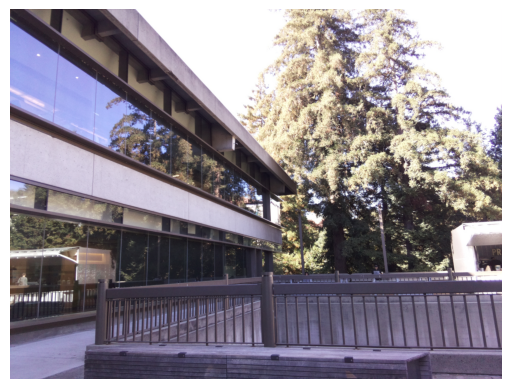
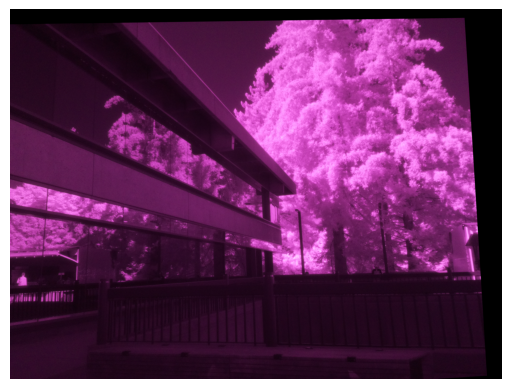

In [16]:
%%compare
display(f"{BASE_IMAGE_DIR}/{FILE_NAME}", H, w, h)


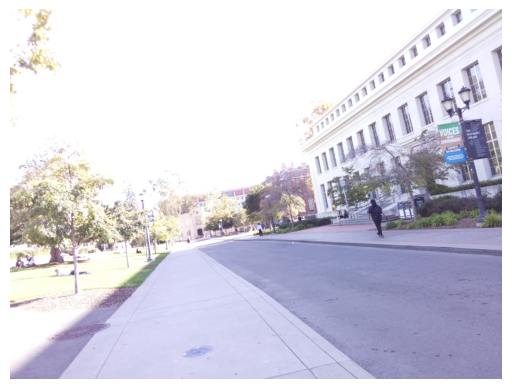
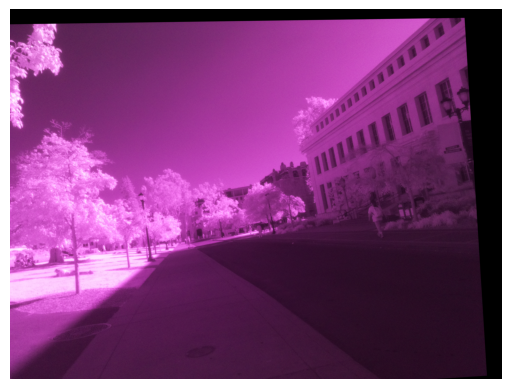

In [17]:
%%compare
display(f"{BASE_IMAGE_DIR}/{FILE_NAMES[2]}", H, w, h)


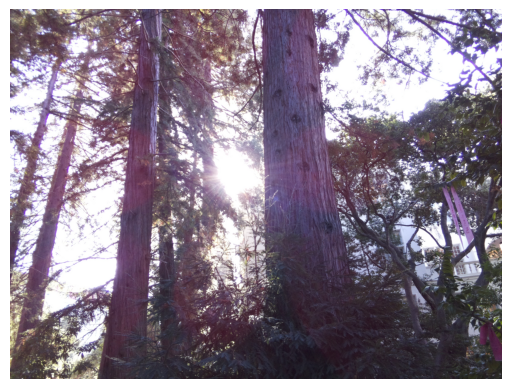
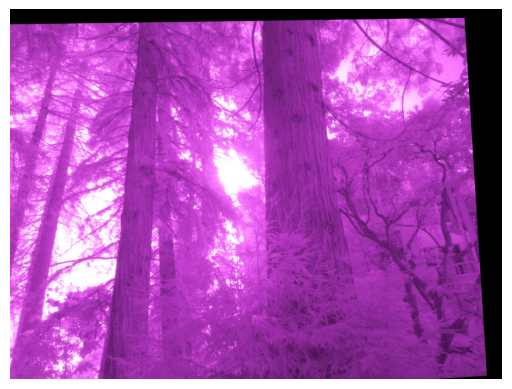

In [18]:
%%compare
display(f"{BASE_IMAGE_DIR}/{FILE_NAMES[3]}", H, w, h)

## Convert All Images to Combined Format

In [19]:
# Note: we use the same homography matrix H that is computed using the "2021-11-15_22-52-14.jpg" sample.

im = cv2.imread(f"VIS_IR_DATASET/2021-11-15_22-52-14.jpg")
im_vis = im[:, :(im.shape[1]//2), :]
im_ir = im[:, (im.shape[1]//2):, :]

H, (w, h) = get_homography(im_ir, im_vis, 2000, 0.2)

file_names = listdir_nohidden(BASE_IMAGE_DIR)
save_dir = "combined"
for file_name in file_names:
    print(f"FILENAME: {BASE_IMAGE_DIR}/{file_name}")
    im = cv2.imread(f"{BASE_IMAGE_DIR}/{file_name}")
    im_vis = im[:, :(im.shape[1]//2), :]
    im_ir = im[:, (im.shape[1]//2):, :]
    
    combine_vis_ir(im_vis, im_ir, H, w, h, save_dir, file_name)

FILENAME: VIS_IR_DATASET/2021-11-15_22-57-01.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_23-13-26.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_22-56-41.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_23-08-16.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_22-55-05.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_22-54-45.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_23-13-19.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_22-58-53.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_23-01-24.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_23-14-05.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_23-22-10.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_22-59-16.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_22-57-13.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_23-14-15.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_23-16-38.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_23-01-08.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_23-08-38.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_23-06-28.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_23-11-30.jpg
FILENAME: VIS_IR_DATASET/2021-11-15_23-02-58.jpg
FILENAME: VIS_IR_DAT